In [1]:
import nbformat

notebook_path = '/home/mderylo/PycharmProjects/ML-Research-Training/NMF Experiment.ipynb'
cleaned_notebook_path = '/home/mderylo/PycharmProjects/ML-Research-Training/NMF Experiment cleaned.ipynb'

# Load the notebook
nb = nbformat.read(notebook_path, as_version=4)

# Remove 'jetTransient' from outputs
for cell in nb.cells:
    if 'outputs' in cell:
        for output in cell['outputs']:
            if 'jetTransient' in output:
                del output['jetTransient']

# Save the cleaned notebook
with open(cleaned_notebook_path, 'w') as f:
    nbformat.write(nb, f)

print(f"Cleaned notebook saved as {cleaned_notebook_path}")


Cleaned notebook saved as /home/mderylo/PycharmProjects/ML-Research-Training/NMF Experiment cleaned.ipynb


## Project Title
This project is about making a Non-negative Matrix Factorization (NMF) experiment using Python and visualizing the results.


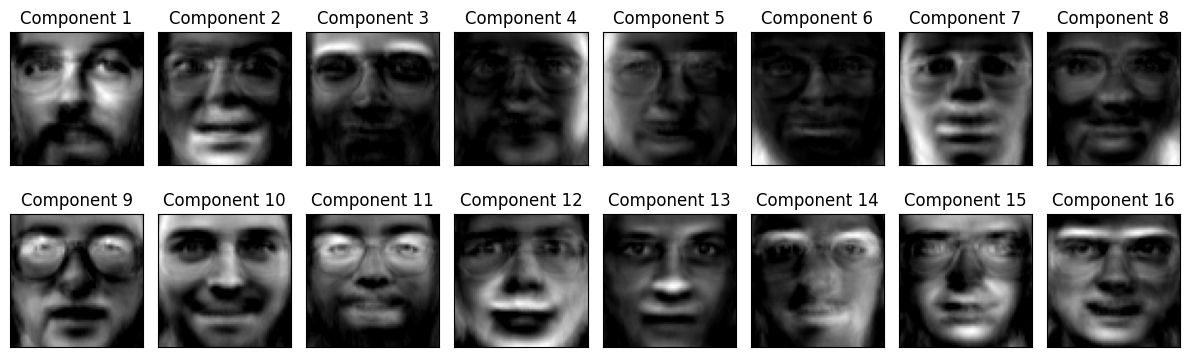

In [28]:
# Python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import NMF

# 1. Load the Olivetti faces dataset
faces = fetch_olivetti_faces(shuffle=True, random_state=42)
X = faces.data
image_shape = faces.images[0].shape

# 2. Apply NMF
n_components = 16
nmf = NMF(n_components=n_components, init='random', random_state=42, max_iter=10000)
W = nmf.fit_transform(X)
H = nmf.components_

# 3. Visualize the NMF components (parts-based representation)
fig, axes = plt.subplots(2, n_components // 2, figsize=(12, 4),
                         subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(H[i].reshape(image_shape), cmap='gray')
    ax.set_title(f'Component {i+1}')
plt.tight_layout()
plt.show()


Here I notice these components can be described as visible faces instad of parts like nose, ears etc.

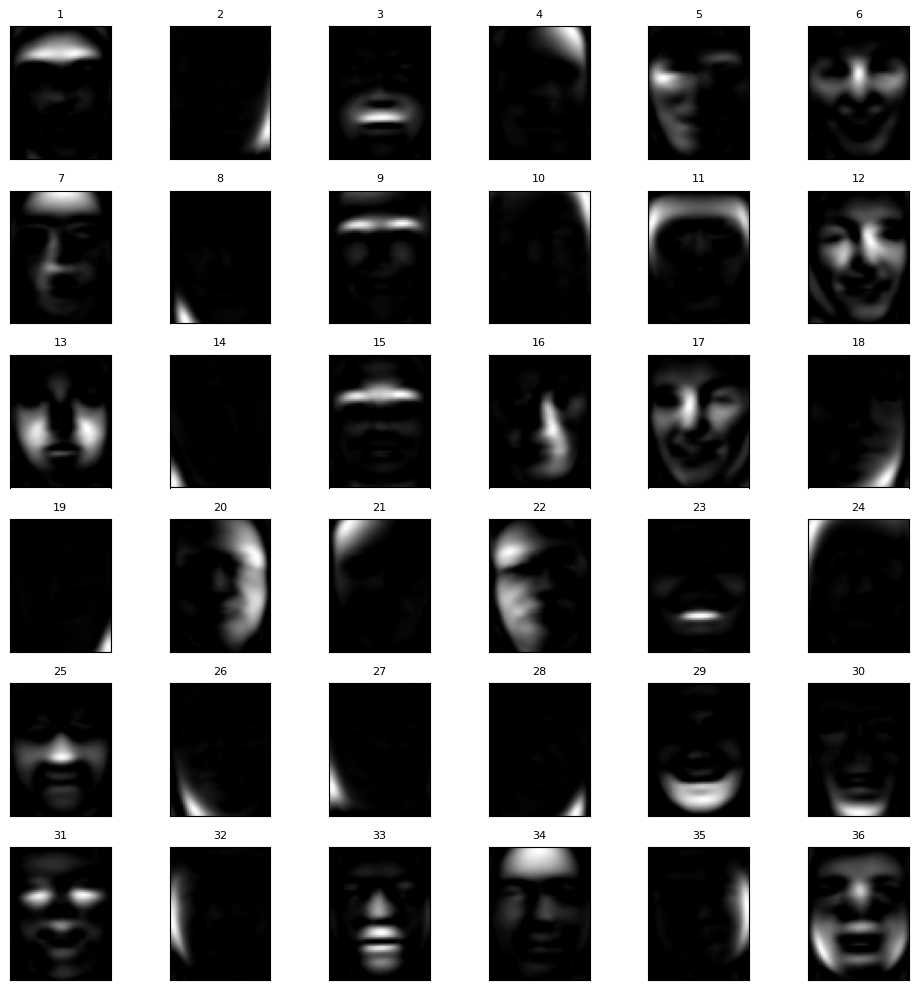

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import tr
from sklearn.decomposition import NMF

lfw = fetch_lfw_people(min_faces_per_person=0, resize=0.5, color=False)
X = lfw.data
image_shape = lfw.images.shape[1:]

n_components = 36
nmf = NMF(n_components=n_components, init='nndsvda', random_state=42, max_iter=10000)
W = nmf.fit_transform(X)
H = nmf.components_

fig, axes = plt.subplots(6, 6, figsize=(10, 10),
                         subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(H[i].reshape(image_shape), cmap='gray')
    ax.set_title(f'{i+1}', fontsize=8)
plt.tight_layout()
plt.show()


samples=200 | test MSE=0.006207 | train recon_err=40.446190
samples=500 | test MSE=0.004738 | train recon_err=71.699516
samples=1000 | test MSE=0.004332 | train recon_err=107.500862
samples=2000 | test MSE=0.004177 | train recon_err=153.365433
samples=4000 | test MSE=0.004107 | train recon_err=216.769272
samples=7331 | test MSE=0.004082 | train recon_err=295.135712
samples=7331 | test MSE=0.004080 | train recon_err=295.109009


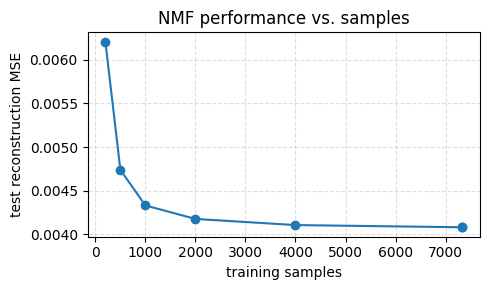

In [34]:
# python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

# 1) Load LFW and filter identities with at least 2 images (needed for stratification)
lfw = fetch_lfw_people(min_faces_per_person=0, resize=0.5, color=False)
X = lfw.data.astype(np.float32)
y = lfw.target

counts = np.bincount(y)
keep_labels = np.where(counts >= 2)[0]
mask = np.isin(y, keep_labels)
X, y = X[mask], y[mask]

# 2) Fixed held-out test set (stratified now safe)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3) Evaluate NMF as training samples increase (unstratified subsampling to avoid per-class count issues)
def eval_nmf(sample_sizes, n_components=64, max_iter=60000, random_state=0):
    rng = np.random.RandomState(random_state)
    results = []
    for size in sorted(s for s in sample_sizes if s > 0):
        size = min(size, len(X_train))
        idx = rng.choice(len(X_train), size=size, replace=False)
        X_sub = X_train[idx]

        nmf = NMF(
            n_components=n_components,
            init='nndsvda',
            random_state=random_state,
            max_iter=max_iter,
            tol=1e-4
        )
        W_train = nmf.fit_transform(X_sub)
        H = nmf.components_

        W_test = nmf.transform(X_test)
        X_test_hat = W_test @ H
        mse = float(np.mean((X_test - X_test_hat) ** 2))
        results.append((size, mse))
        print(f"samples={size} | test MSE={mse:.6f} | train recon_err={nmf.reconstruction_err_:.6f}")
    return results

sample_sizes = [200, 500, 1000, 2000, 4000, 8000, len(X_train)]
results = eval_nmf(sample_sizes, n_components=64, max_iter=60000, random_state=0)

# 4) Plot learning curve
sizes, mses = zip(*results)
plt.figure(figsize=(5, 3))
plt.plot(sizes, mses, marker='o')
plt.xlabel('training samples')
plt.ylabel('test reconstruction MSE')
plt.title('NMF performance vs. samples')
plt.grid(True, ls='--', alpha=0.4)
plt.tight_layout()
plt.show()



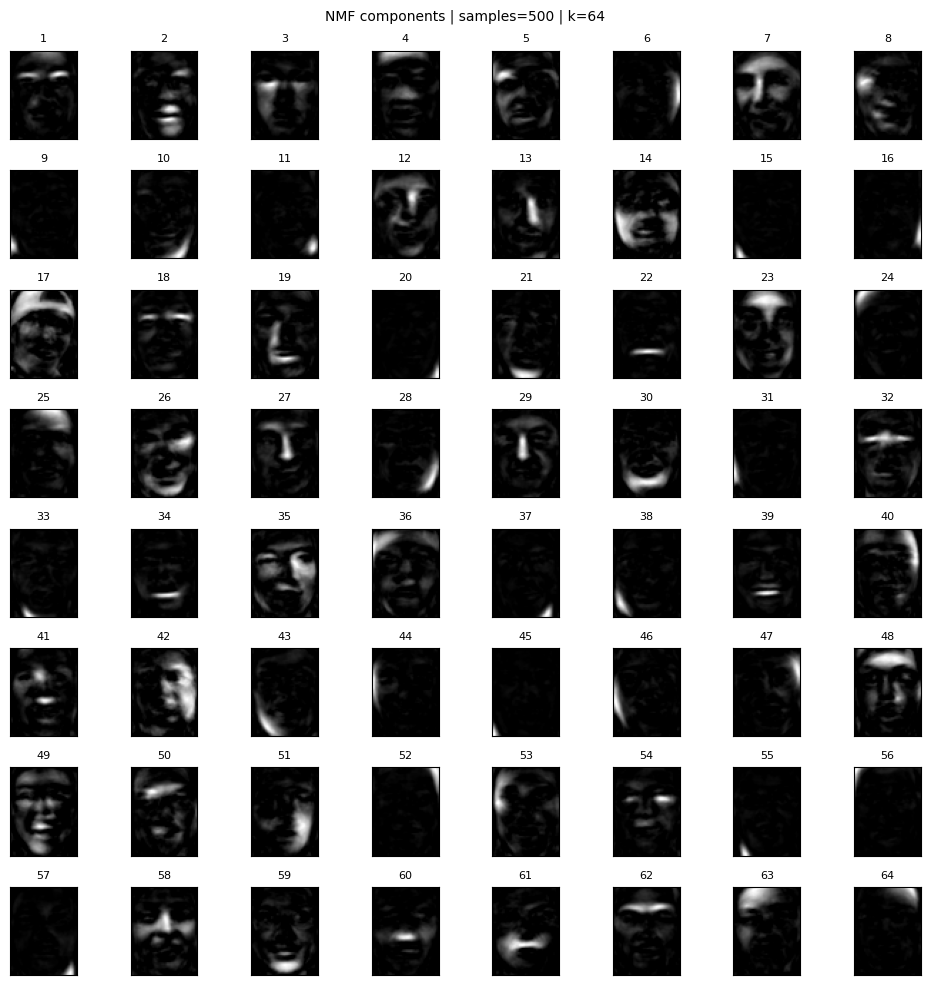

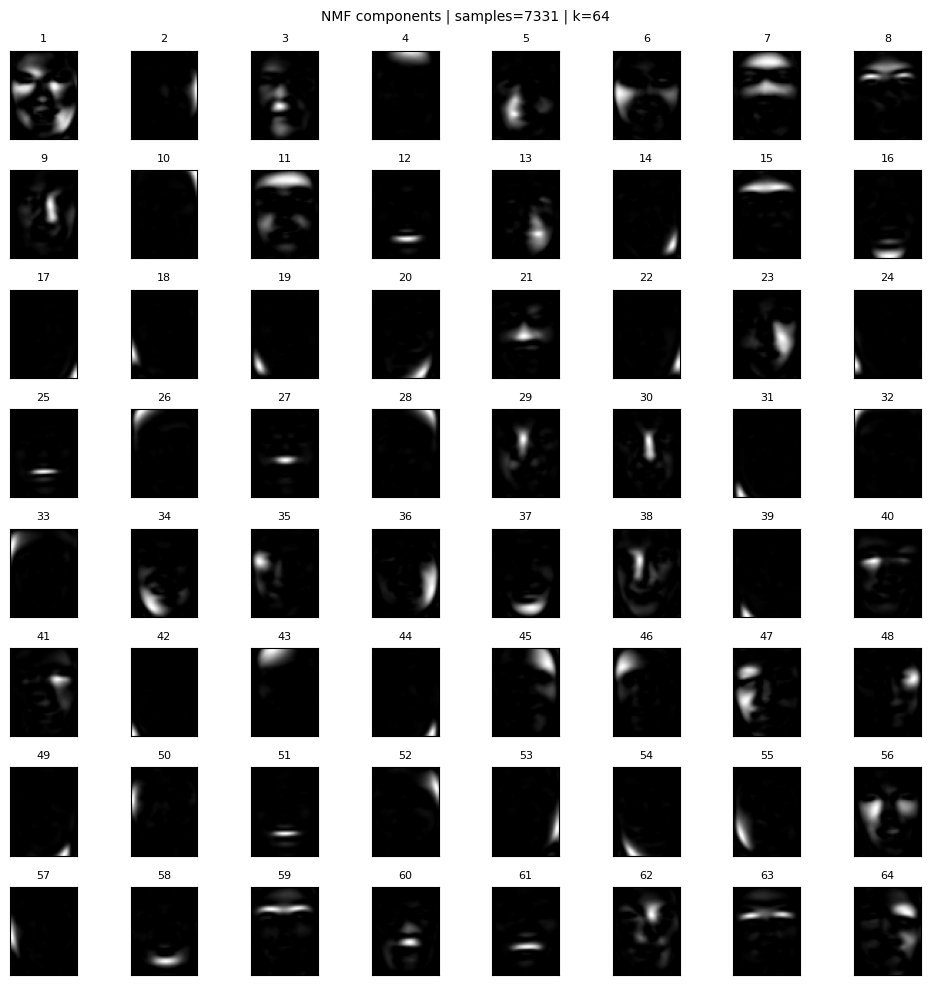

In [38]:
# python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

def visualize_components_by_size(
    X_train, image_shape, sample_sizes, n_components=64,
    max_iter=1000, random_state=0
):
    assert np.prod(image_shape) == X_train.shape[1], "image_shape does not match feature dimension."
    assert n_components == 64, "For an 8x8 grid, set n_components=64."

    rng = np.random.RandomState(123)

    for size in sorted(s for s in sample_sizes if s > 0):
        size = min(size, len(X_train))
        idx = rng.choice(len(X_train), size=size, replace=False)
        X_sub = X_train[idx]

        nmf = NMF(
            n_components=n_components,
            init='nndsvda',
            random_state=random_state,
            max_iter=max_iter,
            tol=1e-4
        )
        nmf.fit(X_sub)
        H = nmf.components_

        fig, axes = plt.subplots(8, 8, figsize=(10, 10),
                                 subplot_kw={'xticks': [], 'yticks': []})
        for i, ax in enumerate(axes.flat):
            ax.imshow(H[i].reshape(image_shape), cmap='gray')
            ax.set_title(f'{i+1}', fontsize=8)

        fig.suptitle(f'NMF components | samples={size} | k={n_components}', y=0.98, fontsize=10)
        plt.tight_layout()
        plt.show()

# Ensure image_shape matches LFW
image_shape = lfw.images.shape[1:]
assert np.prod(image_shape) == X_train.shape[1]

# Example call (uses your existing sample_sizes)
visualize_components_by_size(
    X_train, image_shape, sample_sizes=[500, len(X_train)],
    n_components=64, max_iter=6000, random_state=0
)

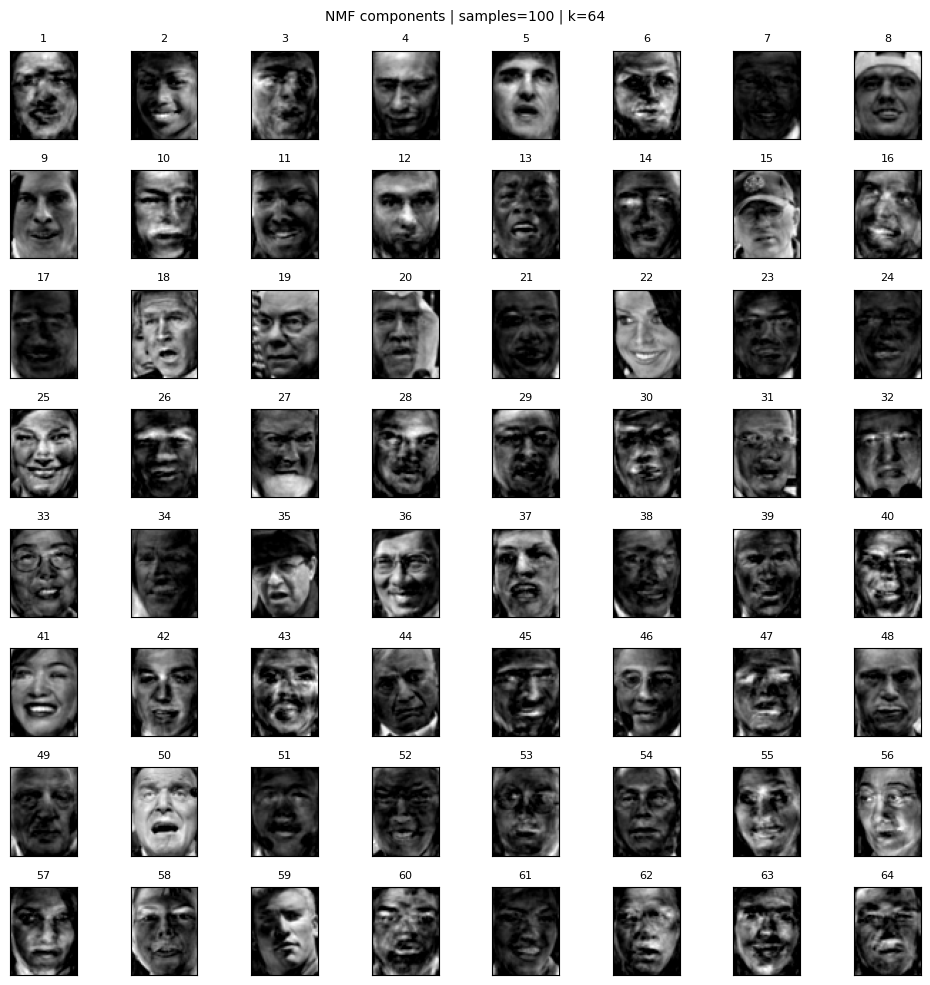

In [39]:
# Example call (uses your existing sample_sizes)
visualize_components_by_size(
    X_train, image_shape, sample_sizes=[100],
    n_components=64, max_iter=6000, random_state=0
)

To compile the learnings from these experiments I find:
1. NMF does indeed learn parts based representation given that the amount of features is significantly smaller than the amount of samples the model is trained on.
2.